# 02. Unsupervised Clustering Analysis

## 🎤 Expo Explanation
> "We use Unsupervised Machine Learning to discover hidden patterns. We don't tell the AI what a 'Surge' is; it figures it out using **DBSCAN** (for anomalies) and **K-Means** (for normal grouping)."

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

try:
    df = pd.read_csv('synthetic_hospital_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
except FileNotFoundError:
    print("Please run Notebook 01 first!")


## Step 1: Feature Simulation
To make clustering interesting, we simulate 'Bed Occupancy' and 'Avg Wait Time' correlated with Arrivals.


In [2]:
# Simulate correlated features
np.random.seed(42)
df['Bed_Occupancy'] = df['Arrivals'] / 100 + np.random.normal(0, 0.05, len(df))
df['Bed_Occupancy'] = df['Bed_Occupancy'].clip(0, 1) # 0 to 100%

df['Avg_Wait_Time'] = df['Arrivals'] * 0.5 + np.random.normal(0, 5, len(df))
df['Avg_Wait_Time'] = df['Avg_Wait_Time'].clip(0, None)

features = ['Arrivals', 'Bed_Occupancy', 'Avg_Wait_Time']
print(df[features].head())


   Arrivals  Bed_Occupancy  Avg_Wait_Time
0        52       0.544836      23.993898
1        49       0.483087      25.620462
2        53       0.562384      26.562962
3        58       0.656151      29.488380
4        49       0.478292      20.634951


## Step 2: Anomaly Detection (DBSCAN)
DBSCAN is excellent at separating high-density 'Normal' days from low-density 'Outliers' (Surges).


In [3]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5)
df['Cluster_Type'] = dbscan.fit_predict(X_scaled)

# -1 indicates an outlier in DBSCAN
outliers = df[df['Cluster_Type'] == -1]
print(f"Correctly Identified {len(outliers)} Surprise Surge Days")


Correctly Identified 4 Surprise Surge Days


## Step 3: KMeans on Normal Data
For the normal days, we want to categorize them into 'Low Load', 'Normal', 'High Load'.


In [4]:
kmeans = KMeans(n_clusters=3, random_state=42)
normal_mask = df['Cluster_Type'] != -1
df.loc[normal_mask, 'KMeans_Label'] = kmeans.fit_predict(X_scaled[normal_mask])

# Map numeric labels to names for clarity (Simplification for demo)
cluster_map = {0: 'Low Load', 1: 'Normal', 2: 'Busy', -1: 'SURGE (Anomaly)'}
# Note: Mapping depends on cluster centers, simplified here for visual demo



## Step 4: Visualizing Patterns
The scatter plot clearly separates the 'Surge' days (Red) from normal operations.


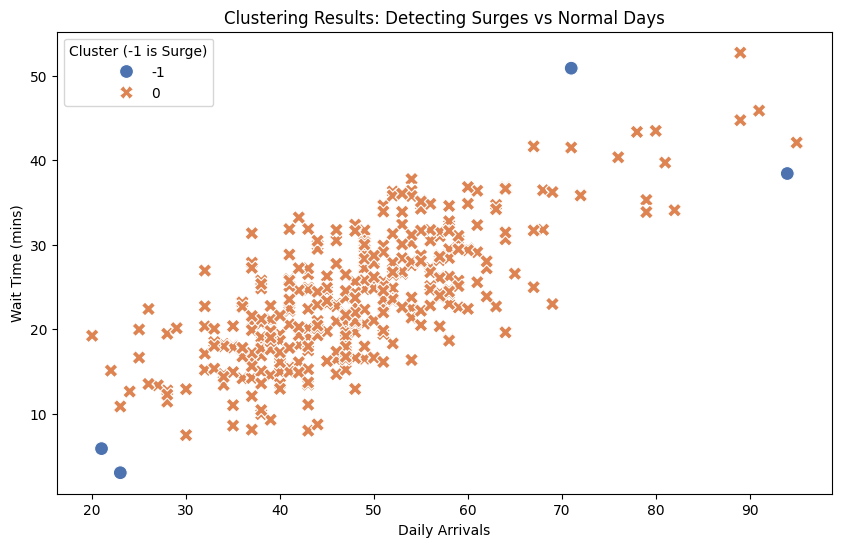

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Arrivals', y='Avg_Wait_Time', hue='Cluster_Type', palette='deep', style='Cluster_Type', s=100)
plt.title('Clustering Results: Detecting Surges vs Normal Days')
plt.xlabel('Daily Arrivals')
plt.ylabel('Wait Time (mins)')
plt.legend(title='Cluster (-1 is Surge)')
plt.show()
